In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import imageio
import re
import video2tfrecord as vid2tf

print('tf: '+tf.__version__)
print('cv: '+cv.__version__)

tf: 2.3.0
cv: 4.0.1


FUNCTIONS TO MANIPULATE AND PLAY VIDEOS

In [2]:
#Function that plays the videos within a directory
def play_videos(directory):
    
    for video_name in os.listdir(directory):
    # try:
            cap=cv.VideoCapture(directory+video_name)
            while cap.isOpened():
                ret, frame=cap.read()
                if not ret:
                    print("Can't receive frame (stream end?). Exiting...")
                    break
                cv.imshow('frame',frame)
                if cv.waitKey(1)==ord('q'):
                    break

            cap.release()
            cv.destroyAllWindows()
#play_videos('../hmdb51_org/fall_floor/')

Define hyperparameters

In [3]:
epochs=10
frame_size=240
batch_size=64
frames_per_video=10

In [4]:
#Function that crops the frames
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

#Function that loads video
def load_video(path, max_frames=0, resize=(frame_size, frame_size)):
  cap = cv.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames)

#Makes a gif out of frames
def to_gif(images):
  converted_images = np.clip(images, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)

#sample_video = load_video('../hmdb51_org/fall_floor/Catch_Me_If_You_Can_fall_floor_f_cm_np1_fr_med_0.avi')[:100]
#to_gif(sample_video)

We get the labels of the HMDB51 dataset

In [5]:
labels = os.listdir('../hmdb51_org')

Function for getting the name and lable of the different train and test split videos.

In [6]:
def get_split(split_number):
    splits_files= os.listdir('../test_train_splits')
    train_split=[]
    test_split=[]
    r = re.compile(str(split_number)+'\.txt$')
    split_files=list(filter(r.search,splits_files))

    for file in split_files:
        
        f=open('../test_train_splits/'+file,'r')
        for line in f:
            if(re.search('1 $',line)):
                train_split.append((line.split(' ',1)[0],file.split('_test',1)[0]))
            elif(re.search('2 $',line)):
                test_split.append((line.split(' ',1)[0],file.split('_test',1)[0]))

        f.close()
    return (train_split,test_split)
train_split1,test_split1=get_split(1)
print()

Instantiate the Xception architecture and freeze the model

In [7]:
pretrained_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(frame_size,frame_size,3),
    classifier_activation='softmax'
)

pretrained_model.trainable=False

We create the model that is going to sit on top of the pretrained model

In [8]:
inputs = tf.keras.Input(shape=(frame_size,frame_size,3))

x = pretrained_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(len(labels),activation='softmax')(x)
model = tf.keras.Model(inputs,outputs)

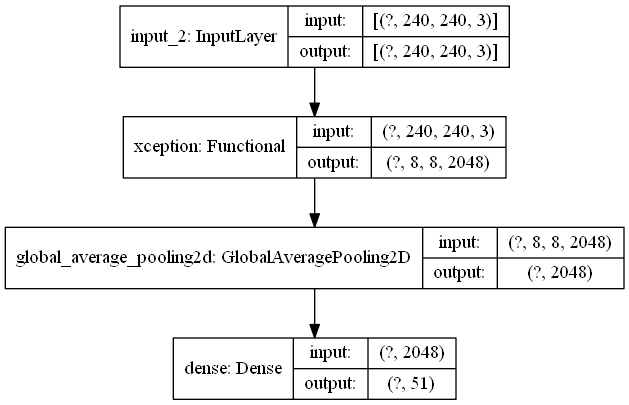

In [9]:
tf.keras.utils.plot_model(model, "modelo_tfg.png", show_shapes=True)

Function that converts the videos from a split into TFRecords

In [ ]:

def split_to_tfrecords(split_data,split_number,n_videos_in_record):
    
    n_of_records=int(len(split_data)/n_videos_in_record)
    hmdb51_directory='../hmdb51_org/'

    i=0
    for batch in range(n_of_records):

        data=[]
        current_batch=split_data[i:i+n_videos_in_record]
        label_of_batch=current_batch[0][1]
    
        for name_and_label in current_batch:
            np_video=load_video(hmdb51_directory+name_and_label[1]+'/'+name_and_label[0],frames_per_video)
            data.append(np_video)
        
        path='../tfRecords/split'+str(split_number)+'/'+label_of_batch
        if not os.path.exists(path):
            os.makedirs(path)
            
        vid2tf.video2tfrecord.save_numpy_to_tfrecords(np.array(data), path, 'trainBatch_', n_videos_in_record,batch+1, total_batch_number=n_of_records, color_depth="uint8")
        i=i+n_videos_in_record

split_to_tfrecords(train_split1,1,70)

In [ ]:
import IPython.display as display
filename=['../tfRecords/split1/brush_hair/trainBatch_1_of_51.tfrecords']
raw_tfrecord=tf.data.TFRecordDataset(filename)

video_feature_description = {
    'blob/0' : tf.io.FixedLenFeature([],tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_video_function(example_proto):
    return tf.io.parse_single_example(example_proto,video_feature_description)

parsed_video_record = raw_tfrecord.map(_parse_video_function)

i=0
for video_features in parsed_video_record.take(1):

    image_raw=video_features['blob/0']
    height=video_features['height']
    width=video_features['width']
    depth=video_features['depth']

    image=tf.io.decode_raw(image_raw,out_type=tf.uint8)
    image = tf.reshape(image, tf.stack([height, width, depth]))
    
    
    display.display(display.Image(data=image))

    
    i=i+1

print(i) 